In [1]:
# import packages
import os
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy.plot as ep

In [2]:
# Read in training data shapefile
shp = gpd.read_file('./data/asheville_9_28.shp')
print(len(shp))
shp.head()

45


,id,class,notes,geometry
0,1,2,None,"POLYGON ((-82.56786 35.57891, -82.56767 35.578..."
1,2,2,None,"POLYGON ((-82.56798 35.57991, -82.56798 35.579..."
2,3,2,"difficult to see edge of flood in shadow, keep?","POLYGON ((-82.56904 35.57638, -82.56881 35.576..."
3,4,2,None,"POLYGON ((-82.56393 35.5759, -82.56393 35.5758..."
4,5,2,None,"POLYGON ((-82.56555 35.57412, -82.56542 35.574..."


In [3]:
# Read in PS image and check number of bands
ps_bands = rio.open('./data/20240928_153924_25_24c8_3B_AnalyticMS_SR.tif')
ps_stack = ps_bands.read()
print(ps_stack.shape, ps_stack.dtype, type(ps_stack))

(4, 8319, 11475) uint16 <class 'numpy.ndarray'>


In [4]:
# Check crs of bands and shapefile
shp = shp.to_crs('EPSG:32617')
print(ps_bands.crs)
print(shp.crs)

EPSG:32617
EPSG:32617


c:\Users\Darcy\anaconda3\envs\GIS495\Lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


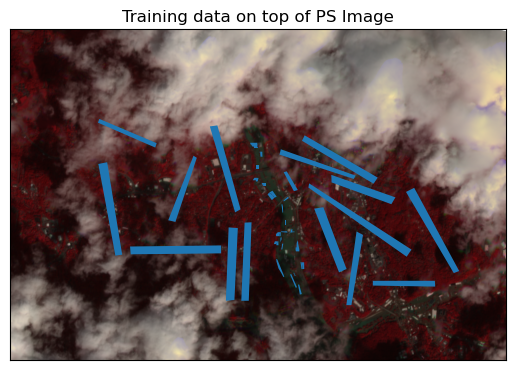

In [5]:
# Plot polygons over raster
import rioxarray as rxr

image = rxr.open_rasterio('./data/20240928_153924_25_24c8_3B_AnalyticMS_SR.tif', masked=True)
clipped_image = image[:, 1000:3000, 3000:6000]
ps_plotting_extent = plotting_extent(clipped_image[0], clipped_image.rio.transform())

# Plot uncropped array
f, ax = plt.subplots()

ep.plot_rgb(clipped_image.values,
            rgb=[3, 2, 1],
            ax=ax,
            title="Training data on top of PS Image",
            extent=ps_plotting_extent) 

shp.plot(ax=ax)

plt.show()

In [6]:
# Extract geometry of each feature in shp in GeoJSON format
geoms = shp.geometry.values

# check one of the geometries
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] 
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((357939 3938376.0000000005, 357957.0000000015 3938375.9999999995, 357939.00000000006 3938271, 357918.0000000005 3938271, 357917.9999999986 3938273.999999999, 357921.00000000035 3938273.999999998, 357921.0000000002 3938280.0000000005, 357923.99999999994 3938279.999999998, 357923.9999999994 3938298, 357926.99999999965 3938298, 357927.00000000023 3938310.0000000005, 357930.00000000023 3938309.999999999, 357930.00000000035 3938336.999999999, 357933.0000000004 3938336.999999999, 357933.00000000047 3938348.9999999995, 357933.0000000001 3938367, 357936.00000000035 3938367, 357936.0000000001 3938372.9999999995, 357938.9999999996 3938372.999999999, 357939 3938376.0000000005))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((357939.0, 3938376.0000000005), (357957.0000000015, 3938375.9999999995), (357939.00000000006, 3938271.0), (357918.0000000005, 3938271.0), (357917.9999999986, 3938273.999999999), (357921.00000000035, 3938273.999999998), 

In [7]:
# extract raster values within the polygon
from rasterio.mask import mask
out_image, out_transform = mask(ps_bands, feature, crop=True)
out_image.shape

(4, 35, 15)

In [8]:
# close rasterio dataset
ps_bands.close()

#### Building Training Data for scikit-learn

In [9]:
# Create array X with all the pixels and arary Y with training indicies
X = np.array([], dtype=np.int8).reshape(0,4) 
y = np.array([], dtype=np.int8) 

In [10]:
# extract raster values within the polygon
with rio.open('./data/20240920_162515_24_24f5_3B_AnalyticMS_SR.tif') as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands (not part of the shapefile)
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all bands (not actually part of the shapefile)
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shp['class'][index]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X = np.vstack((X,out_image_reshaped))

In [11]:
X

array([[ 627,  674,  757,  809],
       [ 809,  760,  542,  629],
       [ 696,  771,  810,  810],
       ...,
       [4068, 4241, 4246, 4104],
       [4186, 4113, 4135, 4072],
       [3850, 3896, 3795, 3905]], dtype=int32)

In [12]:
y

array([2, 2, 2, ..., 0, 0, 0])

In [13]:
# What are our classification indexes?
labels = np.unique(shp['class'])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, classes=labels))
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 2 classes: [0 2]

Our X matrix is sized: (311864, 4)
Our y array is sized: (311864,)


Training RF classifier

In [14]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# test_size = 0.25 >> i.e. 25% of the data; represents the proportion of the dataset to include in the test split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 8) 

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (233898, 4)
Training Labels Shape: (233898,)
Testing Features Shape: (77966, 4)
Testing Labels Shape: (77966,)


In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 8)
# Fit the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(random_state=8)

In [17]:
# Clip stack
clipped_ps_stack = ps_stack[:, 1000:3000, 3000:6000]
print(clipped_ps_stack.shape)

(4, 2000, 3000)


In [18]:
from rasterio.plot import reshape_as_image
reshaped_ps_stack = reshape_as_image(clipped_ps_stack)
print(reshaped_ps_stack.shape, type(reshaped_ps_stack))

(2000, 3000, 4) <class 'numpy.ndarray'>


In [19]:
class_prediction = rf.predict(reshaped_ps_stack.reshape(-1,4))

In [20]:
# Reshape our classificaiton map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_ps_stack[:,:,0].shape)

In [21]:
class_prediction
np.unique(class_prediction, return_counts=True)

(array([0, 2]), array([5889792,  110208]))

In [22]:
class_prediction.shape

(2000, 3000)

In [23]:
# define function to stretch the color for better viz
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rio.plot.adjust_band(colors[:, :, b])
    return colors

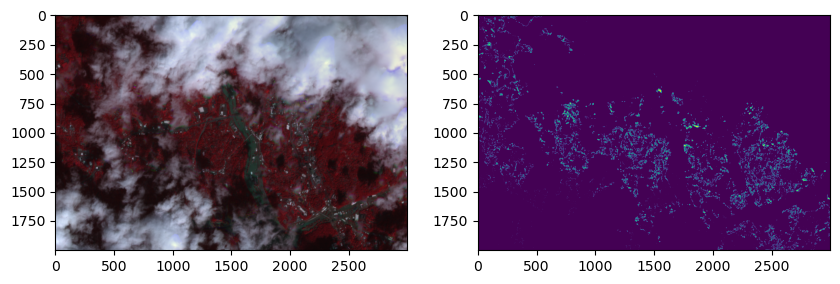

In [24]:
# Let's look at the results
fig, axs = plt.subplots(1,2,figsize=(10,8))

img_stretched = color_stretch(reshaped_ps_stack, [3,2,1])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction)